In this code we are going to use some hyperparameter tuning techniques 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 4.8 MB/s eta 0:00:00


In [2]:
# importing frequently used packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing pytorch related packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
import torchvision.transforms as transforms

# importing required packages for hyperparameter tuning
import skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
# check if CUDA is available and print GPU info
use_cuda = torch.cuda.is_available()
print(use_cuda)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

# set device to use GPU if available, otherwise use CPU
device = torch.device('cuda:0' if use_cuda else 'cpu')

True
1
0
Tesla T4


In [4]:
# Define the custom dataset
class MyDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.data.iloc[index, :-1].values, dtype=torch.float32)
        y = torch.tensor(self.data.iloc[index, -1], dtype=torch.float32)
        return x, y

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data.csv')

x = df.iloc[:, :6].values  # select all rows and the first 6 columns
y = df.iloc[:, -1].values  # select all rows and the last column

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

y = y.reshape(-1, 1)

In [37]:
# Load the dataset
dataset = MyDataset('/content/drive/MyDrive/Colab Notebooks/Data.csv')

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [38]:
# Set printing options for tensors
torch.set_printoptions(precision=3, threshold=10000, edgeitems=5)

# created dataset checking
print(f"Number of samples in train_data: {len(train_data)}")
print(f"Number of samples in val_data: {len(val_data)}")
print(f"Number of samples in test_data: {len(test_data)}")

# Print a few samples from the training set
for x, y in val_data:
    print("Sample input:")
    print(x)
    print("Sample output:")
    print(y)
    break  # stop after printing one batch

Number of samples in train_data: 717
Number of samples in val_data: 153
Number of samples in test_data: 155
Sample input:
tensor([ 5.800e+01,  1.280e+02,  5.200e+01,  1.583e+05,  4.544e+06, -3.420e-01])
Sample output:
tensor(1.858)


In [39]:
for batch in train_loader:
    x, y = batch  # Unpack the batch into inputs and targets
    # Do something with x and y
    
y = y.reshape(-1, 1)

In [8]:
import torch
import torchvision.transforms as transforms

# Calculate the mean and standard deviation for each feature
mean = torch.mean(x, dim=0)
var = torch.var(x, dim=0)

x = (x-mean)/torch.sqrt(var)

In [9]:
# Utility function to report best scores (found online)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [10]:
class MyModule(nn.Module):
    def __init__(self, layer_sizes=[6, 10, 1], activations=[nn.LeakyReLU()], dropouts=[0.5]):
        super(MyModule, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(activations):
                layers.append(activations[i])
            if i < len(dropouts):
                layers.append(nn.Dropout(p=dropouts[i]))

        self.module = nn.Sequential(*layers)

    def forward(self, X):
        X = self.module(X)
        return X

In [17]:
layer_sizes = [[6, 14, 1], [6, 20, 1], [6, 28, 1], [6, 36, 1], [6, 42, 1]]
activations = [[nn.LeakyReLU()], [nn.ReLU()], [nn.Tanh()], [nn.Sigmoid()], [nn.ELU()]]
dropouts = [[0.0], [0.2], [0.4], [0.6], [0.8]]
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
learning_rates = [10 ** x for x in np.random.uniform(-5, -2.5, 20)]

params = {
    'module__layer_sizes': layer_sizes,
    'module__activations': activations,
    'module__dropouts': dropouts,
    'optimizer': optimizers,
    'optimizer__lr': learning_rates,
    'max_epochs': [25, 50, 75, 100],
}

In [18]:
# Running Skorch
net = NeuralNetRegressor(
    MyModule,
    criterion=nn.MSELoss,
    max_epochs=10,
    optimizer=optim.Adam,
    optimizer__lr=0.005
)
gs = RandomizedSearchCV(net, params, refit=True, cv=3, scoring='neg_mean_squared_error', n_iter=100)

In [19]:
%%capture
gs.fit(x,y);

In [20]:
# review top 10 results and parameters associated
report(gs.cv_results_,10)

Model with rank: 1
Mean validation score: -0.395 (std: 0.239)
Parameters: {'optimizer__lr': 0.0005498717784967656, 'optimizer': <class 'torch.optim.adam.Adam'>, 'module__layer_sizes': [6, 14, 1], 'module__dropouts': [0.2], 'module__activations': [Tanh()], 'max_epochs': 100}

Model with rank: 2
Mean validation score: -0.403 (std: 0.256)
Parameters: {'optimizer__lr': 0.00012629056643172364, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__layer_sizes': [6, 14, 1], 'module__dropouts': [0.0], 'module__activations': [LeakyReLU(negative_slope=0.01)], 'max_epochs': 100}

Model with rank: 3
Mean validation score: -0.408 (std: 0.386)
Parameters: {'optimizer__lr': 0.0012663459547207177, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__layer_sizes': [6, 42, 1], 'module__dropouts': [0.0], 'module__activations': [Tanh()], 'max_epochs': 50}

Model with rank: 4
Mean validation score: -0.428 (std: 0.241)
Parameters: {'optimizer__lr': 0.0031545046513858214, 'optimizer': <class 'torch.op

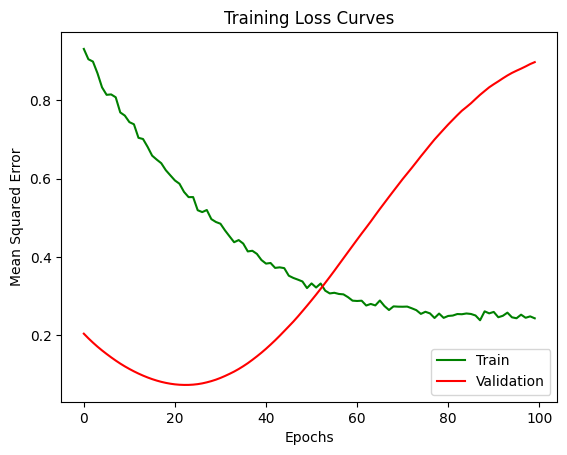

In [21]:
# get training and validation loss
epochs = [i for i in range(len(gs.best_estimator_.history))]
train_loss = gs.best_estimator_.history[:,'train_loss']
valid_loss = gs.best_estimator_.history[:,'valid_loss']

plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

In [26]:
class MyModule(nn.Module):
    def __init__(self, layer_sizes=[6, 10, 1], activations=[nn.LeakyReLU()], dropouts=[0.5], batch_norm=[True]):
        super(MyModule, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            
            # Add batch normalization layer if specified
            if i < len(batch_norm) and batch_norm[i]:
                layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
                
            if i < len(activations):
                layers.append(activations[i])
            if i < len(dropouts):
                layers.append(nn.Dropout(p=dropouts[i]))

        self.module = nn.Sequential(*layers)

    def forward(self, X):
        X = self.module(X)
        return X

In [75]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the model class
class MyModule(nn.Module):
    def __init__(self, layer_sizes=[6, 10, 1], activations=[nn.LeakyReLU()], dropouts=[0.5]):
        super(MyModule, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(activations):
                layers.append(activations[i])
            if i < len(dropouts):
                layers.append(nn.Dropout(p=dropouts[i]))

        self.module = nn.Sequential(*layers)

    def forward(self, X):
        X = self.module(X)
        return X


# Define the ranges for the hyperparameters
#layer_sizes = [[6, 10, 1], [6, 20, 1], [6, 30, 1]]
#activations = [[nn.ReLU()], [nn.Sigmoid()]]
#dropouts = [[0.1], [0.2], [0.3]]

layer_sizes = [[6, 10, 1]]
activations = [[nn.Sigmoid()]]
dropouts = [[0.2]]
learning_rates = [10 ** x for x in np.random.uniform(-5, -2.5, 20)]


# Create lists to store the loss values for each hyperparameter combination
layer_sizes_loss = []
activations_loss = []
dropouts_loss = []
lr_loss = []


# Loop over the hyperparameter ranges and train the model for each combination
for lr in learning_rates:
    for ls in layer_sizes:
        for act in activations:
            for dp in dropouts:

                # Instantiate the model
                model = MyModule(layer_sizes=ls, activations=act, dropouts=dp).to(device)

                # Define the loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Train the model for 50 epochs
                for epoch in range(50):
                    running_loss = 0.0
                    for nn_x, nn_y in train_loader:
                        nn_x, nn_y = nn_x.to(device), nn_y.to(device)
                        pred = model(nn_x)

                        loss = criterion(pred, nn_y)
                        loss.backward()

                        optimizer.step()
                        running_loss += loss.item()

                    #final_loss = running_loss / len(train_loader)
                    #print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

                # Print the hyperparameter values and the final loss value
                print(f"Layer sizes: {ls}, Activations: {act}, Dropouts: {dp}, Loss: {final_loss}")            

                with torch.no_grad():
                    val_loss = 0.0
                    for nn_x, nn_y in val_data:
                        nn_x, nn_y = nn_x.to(device), nn_y.to(device)
                        outputs = model(nn_x)
                        val_loss += criterion(outputs, nn_y).item()
                        val_loss /= len(val_data)
                print(f'Mean squared error on the validation set: {val_loss:.3f}')

                # Store the loss value for the current hyperparameter combination
                layer_sizes_loss.append((ls[1], val_loss))
                activations_loss.append((str(act[0]), val_loss))
                dropouts_loss.append((dp[0], val_loss))
                lr_loss.append((lr, val_loss))



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.000
Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.002
Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.000
Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.002
Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.000
Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.003
Layer sizes: [6, 10, 1], Activations: [Sigmoid()], Dropouts: [0.2], Loss: 361.8736443413628
Mean squared error on the validation set: 0.001
Layer sizes: [6, 10,

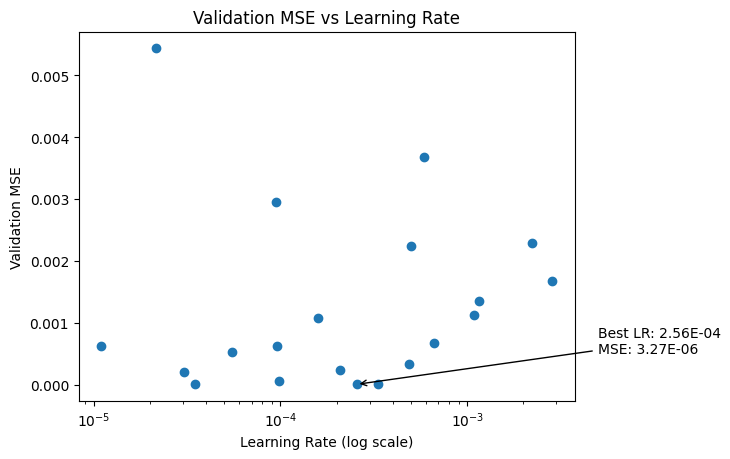

In [89]:
# Extract the learning rates and validation MSEs
learning_rates = [lr[0] for lr in lr_loss]
validation_mses = [lr[1] for lr in lr_loss]

# Find the index of the best learning rate and its corresponding validation MSE
best_idx = validation_mses.index(min(validation_mses))
best_lr = learning_rates[best_idx]
best_mse = validation_mses[best_idx]

# Create the scatter plot
plt.scatter(learning_rates, validation_mses)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Learning Rate')

# Add the label for the best learning rate
plt.annotate(f'Best LR: {best_lr:.2E}\nMSE: {best_mse:.2E}', 
             xy=(best_lr, best_mse), xytext=(0.005, 0.0005),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()